In [1]:
%matplotlib inline 
import matplotlib
%matplotlib widget
print("""
╔════════════════════════════════════════════════════════════════╗
║   SAM2 Video Segmentation: Remove Arm & Gripper from Kinect   ║
╚════════════════════════════════════════════════════════════════╝

This notebook performs interactive arm removal from video:

STEP 1: Interactive Point Annotation
  - Click on arm/gripper in the video to add POS points
  - Click on background to add NEG (negative) points
  - Use these points as prompts for SAM2

STEP 2: SAM2 Video Segmentation
  - Uses your point prompts to segment arm/gripper across video
  - Produces frame-by-frame segmentation masks

STEP 3: Remove Arm using Background
  - Replaces masked regions with first frame background
  - Keeps scene with clean arm-free images

STEP 4: Visualization
  - Shows before/after comparison for selected frames

Output:
  - Final video saved to: VIDEO_PATH_FINAL
  - Processed frames array: frames_no_arm
""")


╔════════════════════════════════════════════════════════════════╗
║   SAM2 Video Segmentation: Remove Arm & Gripper from Kinect   ║
╚════════════════════════════════════════════════════════════════╝

This notebook performs interactive arm removal from video:

STEP 1: Interactive Point Annotation
  - Click on arm/gripper in the video to add POS points
  - Click on background to add NEG (negative) points
  - Use these points as prompts for SAM2

STEP 2: SAM2 Video Segmentation
  - Uses your point prompts to segment arm/gripper across video
  - Produces frame-by-frame segmentation masks

STEP 3: Remove Arm using Background
  - Replaces masked regions with first frame background
  - Keeps scene with clean arm-free images

STEP 4: Visualization
  - Shows before/after comparison for selected frames

Output:
  - Final video saved to: VIDEO_PATH_FINAL
  - Processed frames array: frames_no_arm



In [2]:
import numpy as np
import cv2

def unwrap_obj(x):
    if isinstance(x, np.ndarray) and x.dtype == object:
        try:
            return x.item()
        except Exception:
            return x.tolist()
    return x

def decode_kinect_frame(frame):
    """
    兼容你数据格式：
    frame 是 dict，包含 "data" -> jpeg bytes (np.ndarray uint8 1D / bytes)
    """
    frame = unwrap_obj(frame)

    if isinstance(frame, dict) and "data" in frame:
        buf = frame["data"]
        if isinstance(buf, np.ndarray):
            buf = buf.tobytes()
        elif isinstance(buf, (bytes, bytearray)):
            buf = bytes(buf)
        else:
            buf = bytes(np.array(buf, dtype=np.uint8))

        arr = np.frombuffer(buf, dtype=np.uint8)
        bgr = cv2.imdecode(arr, cv2.IMREAD_COLOR)
        if bgr is None:
            raise ValueError("cv2.imdecode failed for this frame.")
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        return rgb

    # 兜底：如果已经是图像数组
    if isinstance(frame, np.ndarray) and frame.ndim == 3 and frame.shape[-1] == 3:
        if frame.dtype != np.uint8:
            frame = np.clip(frame, 0, 255).astype(np.uint8)
        return frame

    raise TypeError(f"Unsupported kinect frame type: {type(frame)}")

def load_kinect_rgb_frames(npz_path, max_frames=None):
    data = np.load(npz_path, allow_pickle=True)
    if "kinect_rgb" not in data.files:
        raise KeyError(f"'kinect_rgb' not found. Available keys: {list(data.files)}")

    frames_raw = data["kinect_rgb"]
    T = len(frames_raw)
    if max_frames is not None:
        T = min(T, max_frames)

    frames = []
    for i in range(T):
        frames.append(decode_kinect_frame(frames_raw[i]))
    frames = np.stack(frames, axis=0)  # (T,H,W,3) uint8 RGB
    return frames, data

# ====== TODO 改成你的npz路径 ======
NPZ_PATH = "/mnt/WDC10T/tailai_ws/dataset/one_clip_mounting/data_processed_ft/episode_20260227_152342_a7d90d_processed.npz"

frames, npz_data = load_kinect_rgb_frames(NPZ_PATH)
print("frames:", frames.shape, frames.dtype)

# 第一帧无人&无gripper -> 静态背景参考
bg_ref = frames[0].copy()


frames: (297, 720, 1280, 3) uint8


In [3]:
import tempfile
from pathlib import Path
import os

print("Creating video using imageio...")

# 先安装 imageio-ffmpeg
import subprocess
try:
    import imageio
except ImportError:
    print("Installing imageio-ffmpeg...")
    subprocess.check_call(["pip", "-q", "install", "imageio", "imageio-ffmpeg"])
    import imageio

h, w = frames.shape[1], frames.shape[2]
num_frames = len(frames)

print(f"Video: {w}x{h} @ 15fps, {num_frames} frames")
print(f"Frame dtype: {frames.dtype}")

tmp_dir = Path(tempfile.mkdtemp())
VIDEO_PATH = tmp_dir / "kinect_rgb.mp4"

print(f"\nWriting to {VIDEO_PATH}...")

# imageio 接收 RGB 帧，会自动处理编码
with imageio.get_writer(str(VIDEO_PATH), fps=15, codec='libx264', pixelformat='yuv420p') as writer:
    for i, frame in enumerate(frames):
        writer.append_data(frame)
        if (i + 1) % 100 == 0:
            print(f"  {i+1}/{num_frames}")

file_size = os.path.getsize(VIDEO_PATH)
print(f"\n✓ Video saved successfully!")
print(f"✓ File size: {file_size / 1024 / 1024:.2f} MB")
print(f"✓ All {num_frames} frames written")
print(f"\nVideo path: {VIDEO_PATH}")


Creating video using imageio...
Video: 1280x720 @ 15fps, 297 frames
Frame dtype: uint8

Writing to /tmp/tmp9j5dcx95/kinect_rgb.mp4...
  100/297
  200/297

✓ Video saved successfully!
✓ File size: 2.77 MB
✓ All 297 frames written

Video path: /tmp/tmp9j5dcx95/kinect_rgb.mp4


In [4]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# 只保留帧选择 + 清点按钮
idx_slider = widgets.IntSlider(
    min=0, max=len(frames)-1, step=1,
    value=min(10, len(frames)-1),
    description="pick_frame"
)
clear_btn = widgets.Button(description="Clear points")
display(widgets.HBox([idx_slider, clear_btn]))

# 只存 positive 点
click_state = {"pos": []}

fig = go.FigureWidget()
fig.update_layout(width=900, height=550, margin=dict(l=10, r=10, t=10, b=10))

img_trace = go.Image(z=frames[idx_slider.value])
pos_scatter = go.Scatter(
    x=[], y=[],
    mode="markers",
    marker=dict(symbol="cross", size=12),
    name="POS"
)
fig.add_trace(img_trace)
fig.add_trace(pos_scatter)

def refresh_points():
    with fig.batch_update():
        fig.data[1].x = [p[0] for p in click_state["pos"]]
        fig.data[1].y = [p[1] for p in click_state["pos"]]

def on_click(trace, points, selector):
    if len(points.xs) == 0:
        return
    x, y = float(points.xs[0]), float(points.ys[0])
    click_state["pos"].append((x, y))
    refresh_points()

fig.data[0].on_click(on_click)

def on_change_idx(change):
    # 切换帧时清点（更直观；如果你想跨帧保留点，把 clear 那两行删掉）
    global PROMPT_FRAME_IDX
    PROMPT_FRAME_IDX = int(change["new"])
    click_state["pos"].clear()
    with fig.batch_update():
        fig.data[0].z = frames[change["new"]]
    refresh_points()

idx_slider.observe(on_change_idx, names="value")

def on_clear(_):
    click_state["pos"].clear()
    refresh_points()

use_btn = widgets.Button(description="Use this frame")
display(use_btn)

clear_btn.on_click(on_clear)

def on_use(_):
    global PROMPT_FRAME_IDX, POS_POINTS
    PROMPT_FRAME_IDX = int(idx_slider.value)
    POS_POINTS = list(click_state["pos"])
    print("Locked:", PROMPT_FRAME_IDX, "points:", len(POS_POINTS))

use_btn.on_click(on_use)



display(fig)

print("提示：点击图片取 POS 点；点会被存到 click_state['pos']。点完直接运行下一格。")

POS_POINTS = click_state["pos"]  # 你后面用这个就行
PICK_FRAME_SLIDER = idx_slider


Button(description='Use this frame', style=ButtonStyle())

FigureWidget({
    'data': [{'type': 'image',
              'uid': '92ab9fff-4b06-4437-bd56-b65381f03731',
              'z': {'bdata': ('ioqMkJCSj4+RlJSWlZeWkpSTkpSTkJ' ... 'HL0NHL0NHL0NHL0NHLz9DKz9DKz9DK'),
                    'dtype': 'u1',
                    'shape': '720, 1280, 3'}},
             {'marker': {'size': 12, 'symbol': 'cross'},
              'mode': 'markers',
              'name': 'POS',
              'type': 'scatter',
              'uid': '4a9584a2-2085-4219-9bca-46abceb7093a',
              'x': [],
              'y': []}],
    'layout': {'height': 550, 'margin': {'b': 10, 'l': 10, 'r': 10, 't': 10}, 'template': '...', 'width': 900}
})

提示：点击图片取 POS 点；点会被存到 click_state['pos']。点完直接运行下一格。


In [5]:
import os
import imageio.v2 as imageio

BASE_DIR = "/mnt/WDC10T/tailai_ws/adaptive_compliance_policy/data_processed_script/segment/predict"
VIDEO_DIR = os.path.join(BASE_DIR, "frames")
os.makedirs(VIDEO_DIR, exist_ok=True)

# 写成 00000.jpg, 00001.jpg ...
for i, img in enumerate(frames):
    imageio.imwrite(os.path.join(VIDEO_DIR, f"{i:05d}.jpg"), img)

print("Saved frames to:", VIDEO_DIR, " num_frames =", len(frames))


Saved frames to: /mnt/WDC10T/tailai_ws/adaptive_compliance_policy/data_processed_script/segment/predict/frames  num_frames = 297


In [1]:
import os
import torch

from sam2.build_sam import build_sam2_video_predictor

# 你 sam2 repo 的路径（如果你已经在 repo 里跑，这行可以不要）

# os.chdir(SAM2_REPO)
CKPT_PATH = Path("~/sam2/checkpoints/sam2.1_hiera_large.pt").expanduser()
assert CKPT_PATH.exists(), f"ckpt not found: {CKPT_PATH}"


MODEL_CFG = "configs/sam2.1/sam2.1_hiera_l.yaml"  # ✅ 你 repo 里官方就是这么写
predictor = build_sam2_video_predictor(MODEL_CFG, str(CKPT_PATH), device="cuda")


print("CUDA:", torch.cuda.is_available())


ModuleNotFoundError: No module named 'sam2'

In [ ]:
import torch

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    state = predictor.init_state(VIDEO_DIR)

print("State initialized.")


frame loading (JPEG): 100%|██████████| 557/557 [00:09<00:00, 57.78it/s]


State initialized.


In [ ]:
print("PROMPT_FRAME_IDX =", PROMPT_FRAME_IDX)
print("num POS points =", len(POS_POINTS))

print("POS_POINTS sample =", POS_POINTS[:6])



PROMPT_FRAME_IDX = 320
num POS points = 6
POS_POINTS sample = [(982.0, 23.0), (868.0, 54.0), (1174.0, 71.0), (169.0, 224.0), (95.0, 260.0), (58.0, 279.0)]


In [ ]:
import numpy as np
import torch

ann_frame_idx = int(PROMPT_FRAME_IDX)

points = np.array(POS_POINTS, dtype=np.float32)                # (K,2)
labels = np.ones((len(POS_POINTS),), dtype=np.int32)           # (K,) 全是正点

HAND_OBJ_ID = 1

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    frame_idx, obj_ids, mask_logits = predictor.add_new_points_or_box(
        state,
        frame_idx=ann_frame_idx,
        obj_id=HAND_OBJ_ID,
        points=points,
        labels=labels,
    )

print("Added points on frame:", frame_idx, " obj_ids:", [int(x) for x in obj_ids])


Added points on frame: 320  obj_ids: [1]


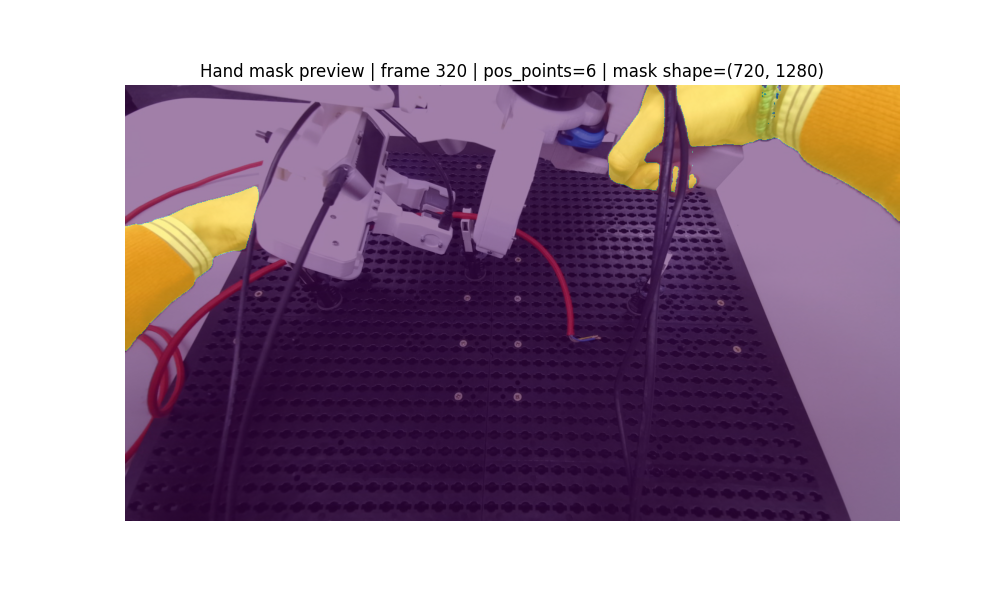

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

obj_ids_list = [int(x) for x in obj_ids]
j = obj_ids_list.index(HAND_OBJ_ID)

ml = mask_logits[j].detach().cpu().numpy()   # 可能是 (1,H,W) 或 (H,W)

# 关键：变成 (H,W)
if ml.ndim == 3 and ml.shape[0] == 1:
    ml = ml[0]
elif ml.ndim == 3:
    # 极端情况（比如 (T,H,W)），取第一张先可视化
    ml = ml[0]

m = (ml > 0)  # bool (H,W)

plt.figure(figsize=(10,6))
plt.imshow(frames[ann_frame_idx])
plt.imshow(m.astype(np.float32), alpha=0.5)  # 转 float 更保险
plt.title(f"Hand mask preview | frame {ann_frame_idx} | pos_points={len(POS_POINTS)} | mask shape={m.shape}")
plt.axis("off")
plt.show()


In [ ]:
import os, glob

VIDEO_DIR = "/home/tailai.cheng/multimodal_flowmatching/scripts/runs/segment/predict/frames"

jpgs = sorted(glob.glob(os.path.join(VIDEO_DIR, "*.jpg")))
print("num jpgs =", len(jpgs))
print("first =", os.path.basename(jpgs[0]) if jpgs else None)
print("last  =", os.path.basename(jpgs[-1]) if jpgs else None)

# 看看是否断号（比如缺 00237.jpg）
if jpgs:
    idxs = [int(os.path.splitext(os.path.basename(p))[0]) for p in jpgs]
    print("min idx =", min(idxs), "max idx =", max(idxs))
    missing = sorted(set(range(min(idxs), max(idxs)+1)) - set(idxs))
    print("missing count =", len(missing))
    print("first missing few =", missing[:20])


num jpgs = 557
first = 00000.jpg
last  = 00556.jpg
min idx = 0 max idx = 556
missing count = 0
first missing few = []


In [ ]:
import numpy as np

def logits_to_mask_hw(mask_logit_tensor):
    """
    Convert SAM2 mask logits tensor to (H,W) boolean mask.
    Handles shapes like:
      (H, W)
      (1, H, W)
      (T, H, W) -> take first
    """
    ml = mask_logit_tensor.detach().cpu().numpy()

    if ml.ndim == 3 and ml.shape[0] == 1:
        ml = ml[0]
    elif ml.ndim == 3:
        ml = ml[0]
    elif ml.ndim != 2:
        raise ValueError(f"Unexpected mask logit shape: {ml.shape}")

    return (ml > 0)


In [ ]:
import torch

masks_all = {}

# 1) forward: 从 ann_frame_idx 往后
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    for f_idx, obj_ids, mask_logits in predictor.propagate_in_video(state):
        obj_ids_list = [int(x) for x in obj_ids]
        if HAND_OBJ_ID not in obj_ids_list:
            continue
        j = obj_ids_list.index(HAND_OBJ_ID)
        m = logits_to_mask_hw(mask_logits[j])
        masks_all[int(f_idx)] = m

print("after forward:", len(masks_all))

# 2) backward: 从 ann_frame_idx 往前
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    for f_idx, obj_ids, mask_logits in predictor.propagate_in_video(state, reverse=True):
        obj_ids_list = [int(x) for x in obj_ids]
        if HAND_OBJ_ID not in obj_ids_list:
            continue
        j = obj_ids_list.index(HAND_OBJ_ID)
        m = logits_to_mask_hw(mask_logits[j])
        masks_all[int(f_idx)] = m

print("after backward:", len(masks_all), "/", len(frames))
print("min frame in masks:", min(masks_all.keys()), "max:", max(masks_all.keys()))


propagate in video: 100%|██████████| 237/237 [00:07<00:00, 30.08it/s]


after forward: 237


propagate in video: 100%|██████████| 321/321 [00:10<00:00, 29.82it/s]

after backward: 557 / 557
min frame in masks: 0 max: 556


In [ ]:
import os
import cv2
import numpy as np

OUT_DIR = "/home/tailai.cheng/multimodal_flowmatching/scripts/runs/segment/predict"
OUT_VIDEO = os.path.join(OUT_DIR, "hand_seg_overlay.mp4")

h, w, _ = frames[0].shape
fps = 15  # 你也可以改成原视频 fps

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUT_VIDEO, fourcc, fps, (w, h))

for i in range(len(frames)):
    img = frames[i].copy()
    m = masks_all.get(i, None)

    if m is not None:
        # 红色 overlay（你可以改颜色）
        overlay = img.copy()
        overlay[m] = (255, 0, 0)
        img = cv2.addWeighted(overlay, 0.5, img, 0.5, 0)

    writer.write(img[:, :, ::-1])  # RGB -> BGR (cv2)

writer.release()
print("Saved video to:", OUT_VIDEO)


Saved video to: /home/tailai.cheng/multimodal_flowmatching/scripts/runs/segment/predict/hand_seg_overlay.mp4


In [ ]:
import os
import cv2
import numpy as np

OUT_DIR = "/home/tailai.cheng/multimodal_flowmatching/scripts/runs/segment/predict"
OUT_VIDEO_NOHAND = os.path.join(OUT_DIR, "video_no_hand_bgfill.mp4")

h, w, _ = frames[0].shape
fps = 15  # 按你的设置

# 背景参考帧：第一帧（你确认手未进入）
bg = frames[0].copy()  # RGB (H,W,3)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUT_VIDEO_NOHAND, fourcc, fps, (w, h))

# 可选：给 mask 做一点点“膨胀”以覆盖边缘（手边缘常有漏/毛刺）
KERNEL = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # 你可改成 (3,3)/(7,7)

for i in range(len(frames)):
    img = frames[i].copy()  # RGB
    m = masks_all.get(i, None)

    if m is not None:
        m_u8 = (m.astype(np.uint8) * 255)
        m_u8 = cv2.dilate(m_u8, KERNEL, iterations=1)  # 可注释掉这一行看差别
        m_bool = m_u8 > 0  # (H,W) bool

        # 用背景像素替换手区域
        img[m_bool] = bg[m_bool]

    writer.write(img[:, :, ::-1])  # RGB -> BGR
writer.release()

print("Saved no-hand video to:", OUT_VIDEO_NOHAND)


Saved no-hand video to: /home/tailai.cheng/multimodal_flowmatching/scripts/runs/segment/predict/video_no_hand_bgfill.mp4
